In [1]:
import random
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# import pandas as ps
import time
import re
import os
import shutil
import glob
import math

(256,)


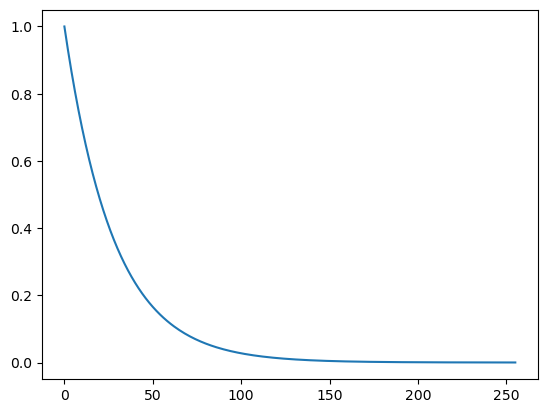

In [2]:
depth = 512
slope = 10000
indices = np.array([2*i for i in range(int(depth/2))], dtype=np.float32)
theta = np.power(slope, - indices / depth)    # (depth/2,)
assert theta.shape[0] == depth/2
print(theta.shape)
plt.plot(theta); plt.show()

(300,)


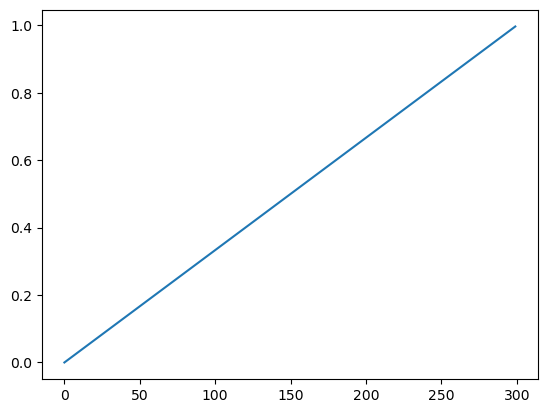

In [3]:
seqLen = 300
memory_eg = np.array([i / seqLen for i in range(seqLen)], dtype=np.float32)
print(memory_eg.shape)
plt.plot(memory_eg); plt.show()

In [4]:
def memory_to_position(memory):
    return memory * seqLen

position = memory_to_position(memory_eg)

radian = position[:, np.newaxis] * theta # (seqLen, depth/2)
print(radian.shape)
# print(radian[1])
cos = np.cos(radian); sin = np.sin(radian)
pEnc = np.stack([cos, sin], axis=-1)    # (seqLen, depth/2, 2)
print(pEnc.shape)
pEnc = pEnc.reshape(pEnc.shape[0], -1)
print(pEnc.shape)

for id in range(int(depth/2)):
    even = np.array([pEnc[id, 2*i] for i in range(int(depth/2))])
    assert (even == cos[id]).all()
    odd = np.array([pEnc[id, 2*i+1] for i in range(int(depth/2))])
    assert (odd == sin[id]).all()

(300, 256)
(300, 256, 2)
(300, 512)


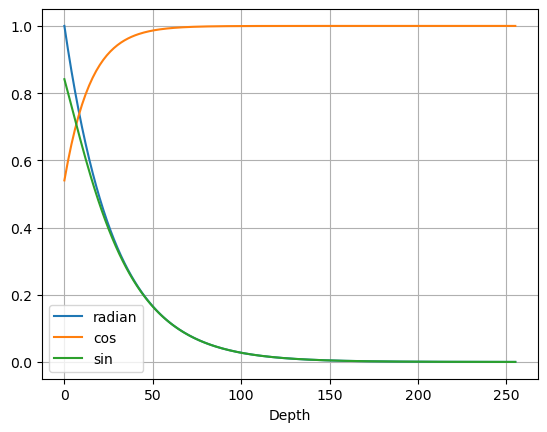

In [5]:
id = 1
plt.plot(radian[id]); plt.plot(cos[id]); plt.plot(sin[id])
plt.legend(['radian', 'cos', 'sin'])
plt.xlabel('Depth')
plt.grid()
plt.show()

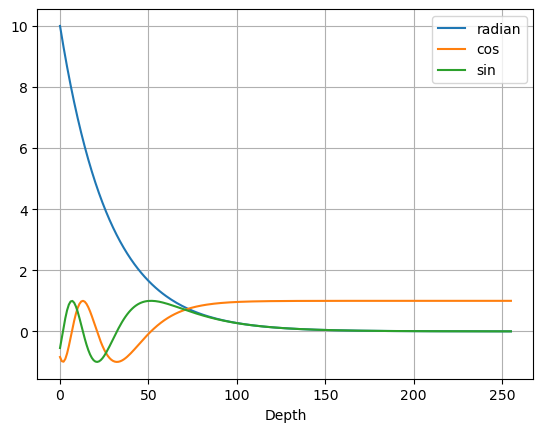

In [6]:
id = 10
plt.plot(radian[id]); plt.plot(cos[id]); plt.plot(sin[id])
plt.legend(['radian', 'cos', 'sin'])
plt.xlabel('Depth')
plt.grid()
plt.show()

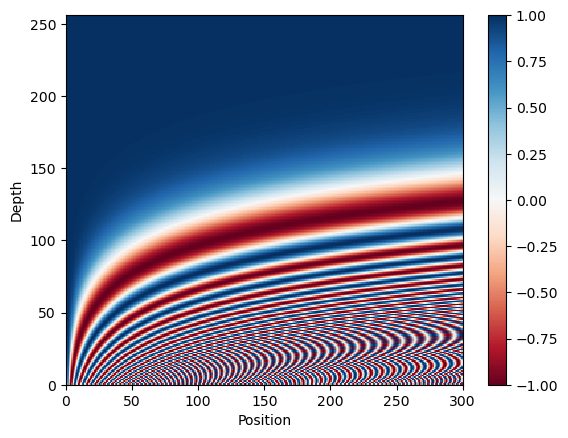

In [7]:
plt.pcolormesh(cos.T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

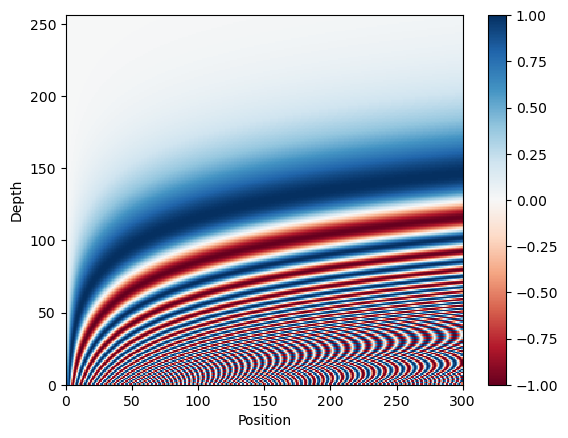

In [8]:
plt.pcolormesh(sin.T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

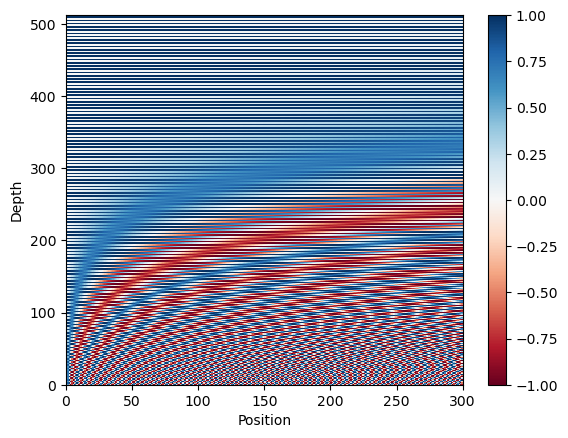

In [9]:
plt.pcolormesh(pEnc.T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

C:\Users\Mike\AppData\Local\Temp\ipykernel_18956\1147873752.py:20: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.xlim([center-sigma, center+sigma])


(0.0, 1.0)

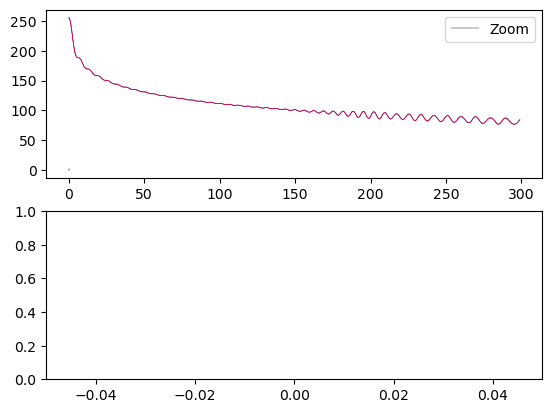

In [10]:
#@title
# pEnc /= tf.norm(pEnc, axis=-1, keepdims=True)
# center = int(depth / 3)
center = 0
sigma = min(center, seqLen-center+1)

plt.subplot(2,1,1)
p = pEnc[center]
dots = tf.einsum('pd,d -> p', pEnc, p)  # dots = np.sum(pEnc * p, axis=-1)
plt.plot(dots, color='b', lw=0.5)
deltaAngle = radian - radian[center]
dots2 = np.sum(np.cos(deltaAngle), axis=-1)
plt.plot(dots2, color='r', lw=0.5)
plt.plot([center-sigma, center-sigma, float('nan'), center+sigma, center+sigma],
         [0,1,float('nan'),0,1], color='k', label='Zoom', lw=0.3)

plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([center-sigma, center+sigma])
plt.ylim([0,1])

In [11]:
# def position_encoding(memory, depth, slope):


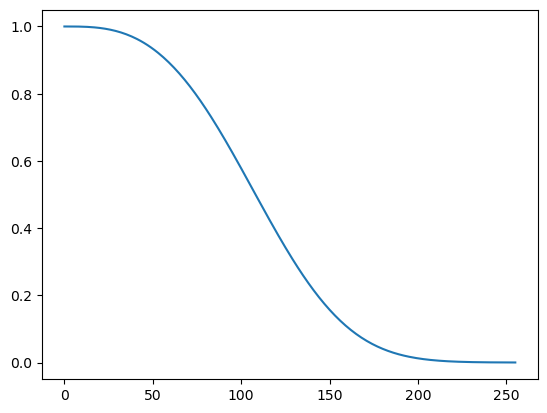

In [103]:
w = 3
exponent = - tf.pow(tf.Variable([2*i for i in range(int(depth/2))], dtype=np.float32) / depth, w)  # (depth/2,)
theta = tf.pow(slope, exponent )  # (depth/2,)
plt.plot(theta); plt.show()

In [97]:
def memory_to_position(memory):
    # memory: (batch, seqLen)
    # return memory * memory.shape[-1]
    return memory * np.pi / 2

def positional_encoding(memory, depth, slope=10000):
    # memory: (batch, seqLen)
    w = 10.0
    exponent = - tf.pow(tf.Variable([2*i for i in range(int(depth/2))], dtype=np.float32) / depth, w)  # (depth/2,)
    theta = tf.pow(slope, exponent )  # (depth/2,)
    # assert theta.shape[0] == depth/2
    pos = memory_to_position(memory) # (batch, seqLen)
    radian = pos[:, :, tf.newaxis] * theta # (batch, seqLen, depth/2)
    pEnc = tf.concat([tf.math.sin(radian), tf.math.cos(radian)], axis=-1)   # (batch, seqLen, depth)
    # cos = tf.cos(radian); sin = tf.sin(radian)  # both (batch, seqLen, depth/2)
    # pEnc = tf.stack([cos, sin], axis=-1)    # (batch, seqLen, depth/2, 2)
    # pEnc = pEnc.reshape(pEnc.shape[0], pEnc.shape[1], -1)   # (batch, seqLen, depth)
    return pEnc  # (batch, seqLen, depth)

seqLen = 300
memory_eg = np.array([[i / seqLen for i in range(seqLen)] for _ in range(100)], dtype=np.float32)

pEnc = positional_encoding(memory_eg, depth=512, slope=10000)   # (batch, seqLen, depth)

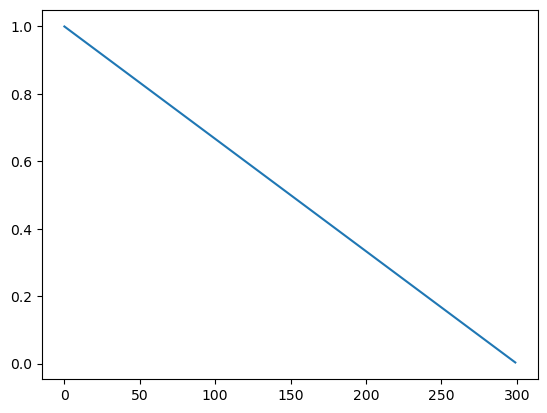

In [98]:
batchSize = 100; seqLen = 300
memory_eg = tf.ones((batchSize,), dtype=tf.float32)[:, tf.newaxis] * (1.0 - tf.range(seqLen, dtype=tf.float32) / seqLen) #  tf.pow(tf.range(seqLen, dtype=tf.float32)/seqLen, 2.0)
plt.plot(memory_eg[0]); plt.show()

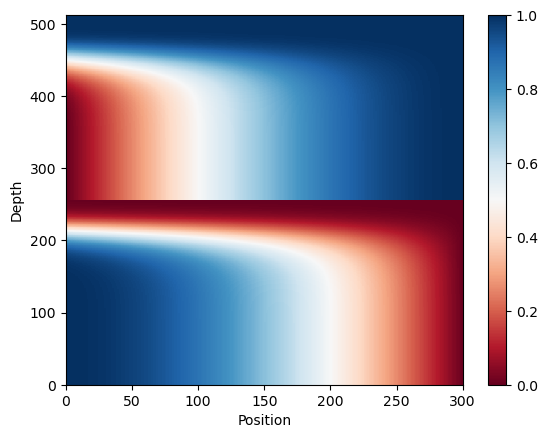

In [99]:
pos_encodings = positional_encoding(memory_eg, depth=512, slope=1000) # (batch, seqLen, depth)
pos_encoding = pos_encodings[0, :, :]   # (seqLen, depth)
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [144]:
def memory_to_position(memory):
    # memory: (batch, seqLen)
    return memory * memory.shape[-1]
    # return memory * np.pi / 2

def positional_encoding(memory, depth, slope=10000):
    # memory: (batch, seqLen)
    w = 0.5
    exponent = - tf.pow(tf.Variable([2*i for i in range(int(depth/2))], dtype=np.float32) / depth, w)  # (depth/2,)
    theta = tf.pow(slope, exponent )  # (depth/2,)
    # assert theta.shape[0] == depth/2
    pos = memory_to_position(memory) # (batch, seqLen)
    radian = pos[:, :, tf.newaxis] * theta # (batch, seqLen, depth/2)
    pEnc = tf.concat([tf.math.cos(radian), tf.math.sin(radian)], axis=-1)   # (batch, seqLen, depth)
    # cos = tf.cos(radian); sin = tf.sin(radian)  # both (batch, seqLen, depth/2)
    # pEnc = tf.stack([cos, sin], axis=-1)    # (batch, seqLen, depth/2, 2)
    # pEnc = pEnc.reshape(pEnc.shape[0], pEnc.shape[1], -1)   # (batch, seqLen, depth)
    return pEnc  # (batch, seqLen, depth)

C:\Users\Mike\AppData\Local\Temp\ipykernel_18956\1880387926.py:23: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  plt.xlim([center-sigma, center+sigma])


(0.0, 1.0)

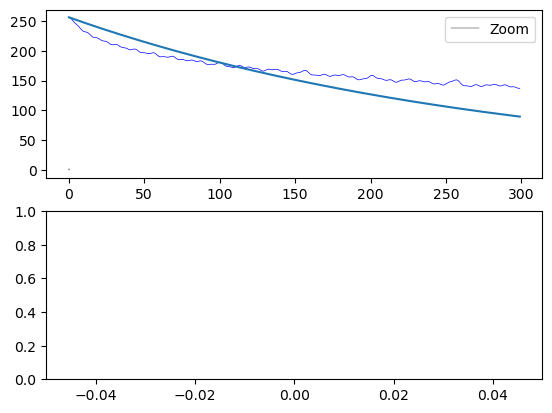

In [148]:
depth = 512
pos_encodings = positional_encoding(memory_eg, depth=depth, slope=10000) # (batch, seqLen, depth)
pos_encoding = pos_encodings[0, :, :]   # (seqLen, depth)
center = 0
sigma = min(center, seqLen-center+1)
plt.subplot(2,1,1)
p = pos_encoding[center]
dots = tf.einsum('pd,d -> p', pos_encoding, p)  # dots = np.sum(pEnc * p, axis=-1)
plt.plot(dots, color='b', lw=0.5)
# deltaAngle = radian - radian[center]
# dots2 = np.sum(np.cos(deltaAngle), axis=-1)
# plt.plot(dots2, color='r', lw=0.5)
plt.plot([center-sigma, center-sigma, float('nan'), center+sigma, center+sigma],
         [0,1,float('nan'),0,1], color='k', label='Zoom', lw=0.3)


m365 = 0.9
x0 = 0.0; y0 = depth/2; x1 = (1.0-m365) * seqLen; y1 = depth/2 * m365
plt.plot(y0 * np.power(y1/y0, np.array(range(seqLen))/x1) )

plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([center-sigma, center+sigma])
plt.ylim([0,1])